# Figures 5

This notebook produces Figure 5 and other auxillary figures.

## Get data

We get the Data from Felikson et al. (2021) and ITS_LIVE (Gardner et al., 2018; Gardner et al., 2019) again. See `Fig3-4.ipynb` for more details.

In [1]:
%%bash

if [ ! -d ../data/Felikson2021/ ]; then
    wget https://zenodo.org/record/4284759/files/netcdfs.zip -P ../data/Felikson2021/ --no-verbose
    unzip ../data/Felikson2021/netcdfs.zip -d ../data/Felikson2021/
    rm -rf ../data/Felikson2021/netcdfs.zip
fi

In [2]:
%%bash

if [ ! -f ../data/GRE_G0240_1998_v.tif ]; then
    wget http://www.geo.cornell.edu/eas/gstudent/wz278/paperdraft2021/GRE_G0240_1998_v.tif -P ../data/ --no-verbose
    wget http://www.geo.cornell.edu/eas/gstudent/wz278/paperdraft2021/GRE_G0240_diff-2018-1998_v.tif -P ../data/ --no-verbose
fi

## Analysis

In [3]:
import pejzero
import rasterio
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

We select and process 104 glaciers with valid key parameters at 3 km from the terminus. And we stick to the same ITS_LIVE rasters we use for Figure 3.

In [4]:
netcdf_dir = '../data/Felikson2021'
glacier_labels = ['0001', '0003', '0004', '0005', '0007', '0009', '0010', '0014', '0015', '0016', 
                  '0019', '0020', '0021', '0022', '0024', '0025', '0027', '0029', '0035', '0036',
                  '0037', '0039', '0043', '0046', '0047', '0048', '0049', '0050', '0052', '0054', 
                  '0058', '0059', '0085', '0099', '0103', '0105', '0106', '0111', '0113', '0114',
                  '0115', '0116', '0124', '0129', '0135', '0152', '0167', '0168', '0174', '0177',
                  '0181', '0183', '0207', '0208', '0212', '0213', '0217', '0245', '0252', '0276',
                  '0277', 'a006', 'a011', 'a030', 'a031', 'a033', 'a034', 'a045', 'a061', 'a112', 
                  'a132', 'a147', 'a148', 'a173', 'a184', 'a199', 'a251', 'a260', 'b006', 'b011',
                  'b030', 'b031', 'b033', 'b034', 'b045', 'b061', 'b132', 'b147', 'b148', 'b173',
                  'b184', 'b199', 'b216', 'b251', 'c031', 'c033', 'c034', 'c061', 'c173', 'c184', 
                  'c216', 'd173', 'd184', 'd216']

glaciers = [netcdf_dir + '/glacier' + i + '.nc' for i in glacier_labels]
print('glaciers total: {}'.format(len(glaciers)))

glaciers total: 104


In [5]:
speed_file = '../data/GRE_G0240_1998_v.tif'
vdiff_file = '../data/GRE_G0240_diff-2018-1998_v.tif'

Process all the selected flowlines and save the results as `mega_results.h5`. We have commented the cell below because it takes some time to run. We have uploaded the results on Zenodo for you to directly read the results. If you do wish to repeat/verify the $P_e$-$J_0$ calculation, you can uncomment the cell below and regenerate the `mega_results.h5` file.

In [6]:
# mega_results = {}

# with rasterio.open(speed_file) as speed_data, rasterio.open(vdiff_file) as vdiff_data:
#     for glacier_file in glaciers:
#         ds = Dataset(glacier_file, 'r')
#         flowline_groups, _ = pejzero.get_flowline_groups(ds)
#         primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]

#         results = {}

#         for flowline_group in primary_flowlines:

#             data_group = pejzero.cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)

#             if data_group is not None:
#                 results[flowline_group.name] = data_group

#         results['avg'] = pejzero.cal_avg_for_each_basin(results)
#         mega_results[Path(glacier_file).stem[-4:]] = results

# pejzero.save_pej0_results(mega_results, "../data/results/mega_results.h5")

Now we read the data from the HDF5 file. If you rerun the cell above and already get the `mega_results` variable, then you can safely comment this cell out.

In [7]:
mega_results = pejzero.load_pej0_results("../data/results/mega_results.h5")

We extract 3 features for each average flowline, convert them to a Pandas dataframe, and save them into a csv file for **Figure 6**:

1. $P_e/\ell$ at 3 km (the closest $P_e/\ell$ reading to the terminus)
2. $J_0$ at 3 km (the closest $P_e/\ell$ reading to the terminus)
3. Speed change

We have commented this cell out because `pej0_GrIS_classification.csv` is along provided along with the workflows. That said, you can always uncomment the cell below and regenerate it.

In [8]:
# to_df = []
# for key in mega_results:
#     to_df.append([next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)), 
#                   next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), 
#                   next(x for x in mega_results[key]['avg']['udiff_sm'] if not np.isnan(x))])
    
# df = pd.DataFrame(to_df, columns=[r'$\frac{P_e}{\ell}$ (1/m)', r'$J_0$ (m/yr)', 'Speed diff (m/yr)'])
# df.to_csv('../data/pej0_GrIS_classification.csv', index=False)

## Visualization

Firstly we design a color map based on the 1998-2018 speed change. This color map uses 7 nodes and strecthes from -500 m/yr to 3500/yr.

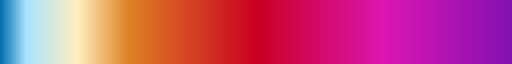

In [9]:
colors = np.array([[5,113,176,255],
                   [171,229,255,255],
                   [255,240,189,255],
                   [222,130,38,255],
                   [202,0,32,255],
                   [220,22,177,255],
                   [132,17,177,255]])
colors = colors / 255
nodes = (np.array([-500, -300, 100, 500, 1500, 2500, 3500]) + 500) / 4000
mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
mycmap

Now we can make **Figure 5** by color coding each average glacier flowline using `mycmap` on the profile and the $J_0$-$P_0/\ell$ plots. 

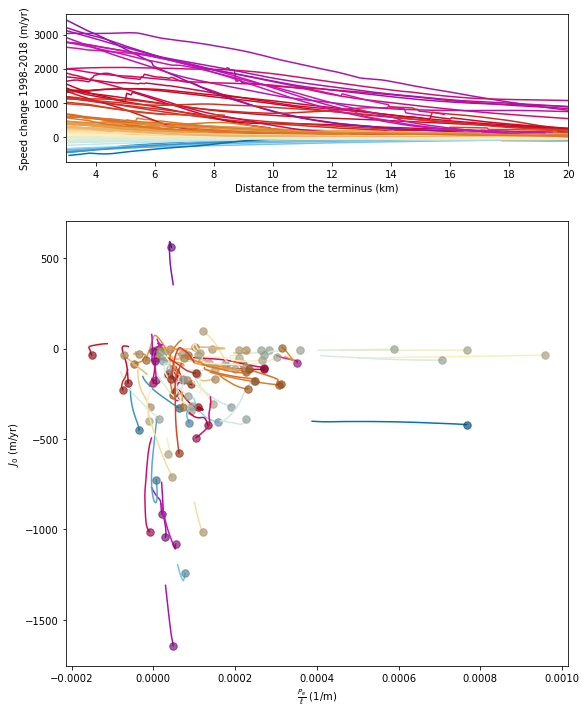

In [10]:
fig, ax4 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(9, 12))

for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    z_value_scaled = (z_value + 500) / 4000
    rgba = mycmap(z_value_scaled)
    rgba2 = np.array(rgba) / 1.5 
    ax4[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['udiff_sm'], color=rgba)
    ax4[0].set_xlim([3, 20])
    ax4[0].set_xlabel('Distance from the terminus (km)')
    ax4[0].set_ylabel('Speed change 1998-2018 (m/yr)')
    ax4[1].plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=rgba)
    ax4[1].plot(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)),
                next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), '.', color=rgba2, markersize=15)
    ax4[1].set_xlabel(r'$\frac{P_e}{\ell}$ (1/m)')
    ax4[1].set_ylabel(r'$J_0$ (m/yr)')
    
fig.savefig('Fig5.pdf')

## Exploring the results

These extra cells provide general overview of the data structure of `mega_results.h5`.

In [11]:
for key in mega_results['a034']:    # This is Alison glacier (see Figure 1). You can replace the ID with any one we select in the beginning of this notebook.
    print(key)

avg
flowline03
flowline04
flowline05
flowline06
flowline07
flowline08


In [12]:
mega_results['a034']['avg']    # Average of Alison's 6 primary flowlines

{'b': array([      nan,       nan,       nan, ..., 602.95337, 603.01636,
        603.074  ], dtype=float32),
 'd': array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 1.3410e+02, 1.3415e+02,
        1.3420e+02], dtype=float32),
 'j0': array([        nan,         nan,         nan, ..., 14.26131558,
        14.80505341, 15.32604264]),
 'j0_ignore_dslope': array([        nan,         nan,         nan, ..., -4.34209113,
        -4.40261348, -4.46299192]),
 'pe': array([           nan,            nan,            nan, ...,
        5.77694301e-05, 5.83274997e-05, 5.88461048e-05]),
 'pe_ignore_dslope': array([           nan,            nan,            nan, ...,
        2.91079403e-05, 2.86310854e-05, 2.81535963e-05]),
 's': array([      nan,       nan,       nan, ..., 2096.6362, 2097.0464,
        2097.4556], dtype=float32),
 'term1': array([          nan,           nan,           nan, ..., 6.9380649e-06,
        6.9413554e-06, 6.9449325e-06], dtype=float32),
 'term2': array([           nan,      